# COGS 188 - Final Project

# Computer Play of Hong Kong Mahjong through Adversarial Deep Q-Learning

## Group members

- Trevor Yip
- Kevin Fisher

# Abstract 
Mahjong is a strategic, stochastic game that serves as an interesting environment to train a ML agent in. This is due to the sheer amount of hidden information, as well as the complex but well-balanced ruleset. The goal of our project is to train an agent that tries to win as quickly as possible. The agent will be trained using temporal difference learning, with neural networks serving as approximations of the q-table, and performance is measured by the average steps per hand and the average win rate of the agent. The architecture that we used includes convolutional layers in order to capture the semantic meaning in the spatial relationships of tiles that are adjacent in terms of suit or rank. The resulting agent performs better than random, but leaves room for future improvements.

# Background

Mahjong is a popular semi-random tile-based game from China, which is also popular in many other Asian countries [1]. Due to its age and popularity, there are many different versions of mahjong, each with slightly different rules. Here we describe Hong Kong mahjong, as it is one of the most popular and simple versions.

To start, the 144 tiles (with 34 unique types of tile) are shuffled and placed into the wall, which is where they will be drawn from. Then each player draws 13 tiles, and the starting player draws a tile. They then discard a tile, and this pattern of drawing a tile then discarding continues around the table. The goal is to create pongs (sets of 3 identical tiles) and chows (runs of 3 adjacent numbered tiles) such that your hand of 13 has 4 melds (the general term for pongs and chows) and one pair made from the extra 14th tile you draw and the remaining tile. This can either be from the tiles you draw, or by stealing a discarded tile if it would allow you to make a meld. Once someone wins, they receive points from the other players based on the specific hand they won with, along with some other factors. This then continues for a minimum of 16 hands [1].

The state of the art Mahjong AI is Suphx, a reinforcement learning-based agent which uses five smaller models to play Mahjong [2]. This achieves excellent performance compared to other agents and even humans, being better than any other agent and at least comparable to, if not better than, every human. This is an agent for riichi mahjong, also known as Japanese mahjong, which appears to have been chosen as there are online lobbies in which one can test agents against humans (tenhou.net) [3]. However, riichi mahjong is also much more complicated, and is not as commonly played by the Chinese demographic. As such, we will continue to use the rules of Hong Kong-style mahjong, but there are some ideas which are relevant to us in Suphx, as they share a common base.

# Problem Statement

The problem that we are solving is to find an optimal strategy to win a single hand of mahjong as quickly as possible. We will be using Hong Kong mahjong, as this will make it simpler to model, as well as more general, as described above. This is as compared to riichi mahjong, which is much more complicated, and has already been explored to a greater extent.

The problem is quantifiable as mahjong has a fixed and defined set of rules, as well as rules for scoring, which is the number we will be maximizing. A given solution to the problem will be measured by the winrate of the agent and the number of turns needed to win; and a game of mahjong can be replicated since it is deterministic given the wall and the hands.

# Data

As there are no existing datasets of Hong Kong-style mahjong that are easily accessible, we will be creating our own dataset by having the model play games against itself. As we will be using temporal difference learning, one observation will be a single state of the game, and we will also record other critical variables, such as the win rate of the model.

To create and collect this data, we will create our own simulator, as there is not an existing one for Hong Kong-style mahjong. The details of this are described below, but it will include the ability to step through the game and ask agents to take moves, where they may choose which tile to discard, and whether to take a meld. This will allow us to train the agent against itself and random agents.

# Proposed Solution

Our proposed solution is to train a model that aims to win as quickly as possible. The learning method that we will be using is temporal difference (TD) learning, specifically Q-learning. We chose this over Monte Carlo as our learning method, as an episode potentially contains a large amount of actions (roughly 30), and waiting for each episode to complete before updating our estimates would slow learning considerably. We also chose this over Dynamic Programming as our learning method, as there are a large number of possible states in the state space, and iterating over all of them would be intractable.

We will be using TD to train a neural network that will serve as an approximation for the Q-function, as the state space is very large. Our inputs to the neural network will consist of the current hand of the agent, the current discarded tiles and the melded tiles of other players. There will be 34 outputs of the neural network, each representing the estimated reward of discarding that type of tile. In order to encourage a balance of exploration and exploitation, we will use epsilon-greedy as a strategy to select actions, though we may also explore other action selection strategies.

Since the agent only directly receives input at the end of each hand, we would experience very slow learning if this was the only way to estimate value. As such, our reward function will incorporate not only winning, but also certain good states, such as having melds. This should allow the choices of the network to be slightly better guided and speed up convergence. Moreover, by using a discount rate, the network will be rewarded for winning faster, since then the impulse of winning would be stronger after propagation.

As a proof of concept, an existing model that uses reinforcement learning made by Microsoft has achieved good performance, but it cannot be used as a benchmark model to compare performance, as it plays mahjong with a different set of rules.

# Evaluation Metrics

There are three evaluation metrics that we will be using to quantify the performance of the agent: the average number of steps that it takes to finish a hand, the average wins that the agent gets across recent hands, and the average score of the agent across recent hands.

All three of these metrics are an average taken over the 100 most recent hands; the number of steps per hand is determined by how many times a player makes a choice over the course of that hand, and the score of the agent per hand is determined as a sum of the rewards that the agent obtained over that hand.

# Results

### Simulator Architecture
The simulator is contained in the `simulator/` folder, and is capable of describing and running a full Mahjong game. In the `game.py` file we have the `Game` class, the central manager of the simulator. It goes through the flow of each step, which roughly represents a turn in the game, and most importantly, it serves as an interface between the agents and the game state, since agents do not have access to anything but their hand and the public melds and discards. It also deals with priority of melds, and giving the turn to the correct player after a meld.

Closely tied to this game object is the `State`, located in `state.py`. While `Game` handles the flow of the simulation, `State` manages the exact manipulation of the tiles, as well as determining useful values like available melds and the winner (if there is one). It has functions to be called by the game in order to discard tiles, meld tiles, and draw tiles. It does not ensure the order of actions is correct; this is done by the game, which is required to implement things like concealed kans and melds.

Other than these two files, there are a variety of other helper classes. `Agent`, in `agent.py`, is an abstract class that represents a general agent, and helps to implement custom agents. There are then various classes to represent melds and tiles. Finally, there is a `util.py` file, which includes a couple of utility functions, the most important of which is converting a tile list to a tensor, which is described in more detail in the next section.

The algorithm used to determine a winning mahjong hand is also of interest; we did not find a performant strategy online, so this was designed entirely from scratch. The central idea is that if there is a tile with no other versions of itself in the hand, the hand can only win if that tile is part of a run. As such, it starts by eliminating all the isolated tiles, then checking if the remaining tiles are all members of sets. This is very efficient, and only requires two passes through the tiles (and not two whole passes, since it caches information about which tiles to revisit). It is certainly possible that this algorithm has been discovered before, but we were not able to find it if so. 

### Agent Architecture

The agent is mainly composed of two neural networks that approximate the two tasks that a player performs: discarding and melding. The two neural networks have similar architectures, with the only difference being their input and output sizes. The discard model takes in the state and returns the type of tile to discard, while the meld model gives a yes or no response to a proposed meld, with it applied to each meld.

The inputs to the network consist of the hand, melds, and discards, which is the same as the publicly available information to a player in a normal game of Mahjong. The meld network specifically also has additional inputs that represent the meld it is considering. Each collection of mahjong tiles is represented as a 34x4 tensor, so by the above the discard network has 9 of these and the meld network has 10; these are passed as the input channels to the network.

The network has two convolutional layers: the first transforms the input channels into 16 output channels with a 3x4 kernel, and the second transforms 16 input channels into 64 output channels with a 32x1 kernel. Then, there is a fully connected layer of 64 inputs to 64 outputs, and the output layer that transforms 64 inputs to the output size. The activation function for each layer is ReLU. We chose not to implement padding or pooling, as these average out or approximate values, but the individual values in our data are very important.

The output size for the discard model is 34, which is a one-hot representation of all playable tiles and represents the possible tiles that the agent could discard. The output size for the meld model is 2, which represents taking and not taking a particular meld. For the meld model in particular, we choose the model with the greatest q-value on yes that does not have a greater value for no.

We chose to use convolutional layers in our model because there is a spatial relationship between adjacent tiles within the same rank, as well as between copies of the same tile. In particular, the 3x4 kernel represents the fact that chi (runs) are of length 3, and sets can be up to length 4. This choice is supported by the fact that the Mahjong model Suphx, as well as the model used in the original Deep Q-Learning paper also used convolutional networks in their model architecture.

Below, we have shown the pytorch architecture of our network:

In [1]:
from learning.models import MahjongNetwork
MahjongNetwork(9, 34, 0)

MahjongNetwork(
  (stack): Sequential(
    (0): Conv2d(9, 16, kernel_size=(3, 4), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 64, kernel_size=(32, 1), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=34, bias=True)
  )
)

### Training Method

We chose to use deep Q-learning to approximate a real Q-table for this environment, as the state space is too large to represent in memory. For example, for the discard model, we would have $9 \times 34 \times 4 = 1224$ dimensions, each with size 2, and 34 actions for each. Thus, if we used floats, this would give $2^{1224} \cdot 34 \cdot 64$ bits. This is roughly $10^{361}$ GB, which (according to Wolfram-Alpha) is around 10 orders of magnitudes larger than the total data stored in the internet. As such, the use of deep Q-learning is appropriate for solving this environment, with the outputs of the neural network determining the agent’s actions.

We used epsilon-greedy as an action selection strategy for the agent, which encourages it to explore sometimes, rather than always following the action that it thinks is optimal. The epsilon value used in training is 0.1.

As Deep Q-learning suffers from instability relative to normal Q-learning, we have implemented a few learning strategies to help stabilize the training: Double Q-learning, Fixed Q-target, and Experience Replay [4].

Double Q-learning is a learning strategy that decreases the maximization bias problem by using a target network and a local network to decouple the process of action selection and q-value generation, where the local network selects the next action, and the target network calculates the q-value.

Fixed Q-target is a learning strategy that updates the target network slower than the local network. Normally, both the target network and the local network are updating at the same time in training, which leads to the local network being unable to catch up to the estimated target values. By using a soft update to update the target network slower, it allows the local network to actually catch up to the target network.

Experience replay is a learning strategy that saves previous states and uses them for training. This is useful as it allows an agent to learn from more than just the immediate state that it is currently in. By randomly sampling stored memories, it also allows the agent to learn from non-consecutive states, as consecutive states are very similar and might bias the agent’s learning.

Finally, we also used adversarial training, where we used self-play in training. Out of the 4 players, two of them were agents connected to the same set of networks, allowing it to learn faster, as well as generalize more, as the problem becomes more difficult with multiple intelligent agents.

### Training Performance

In training, the model quickly converged on all metrics (length of games, win rate, and reward), as can be seen below:

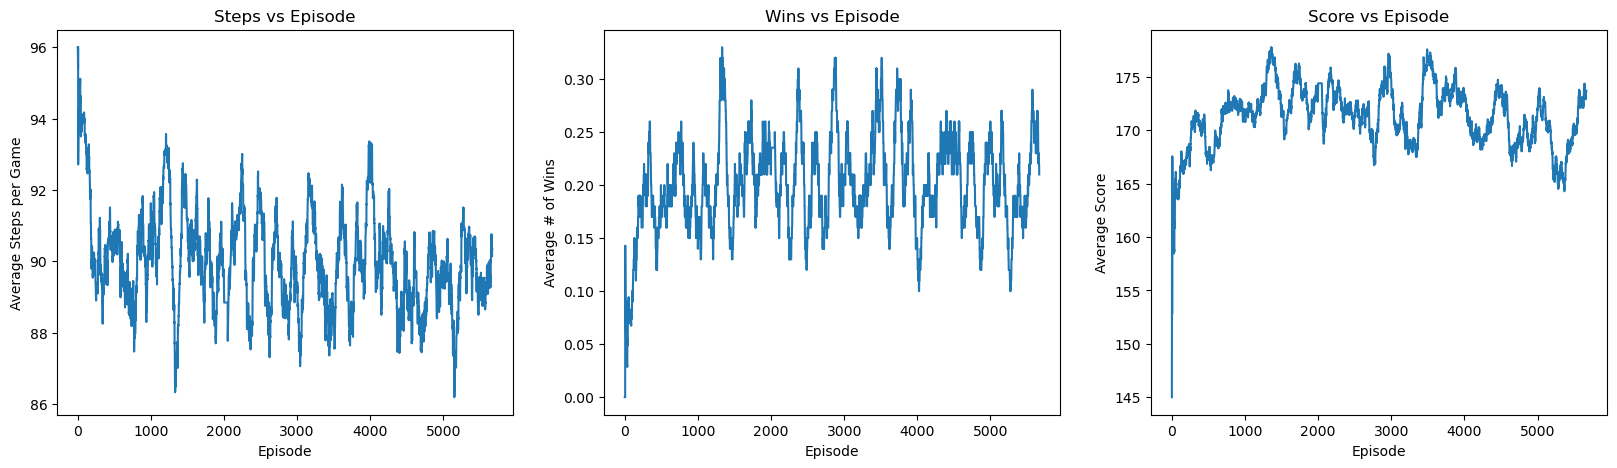

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/data.csv', skiprows=1, names=['episode', 'steps', 'wins', 'scores'])
# Remove the parts in the second training step where it hadn't stabilized
data.loc[2000:2050, 'steps'] = data.loc[2050, 'steps']
data.loc[2000:2050, 'wins'] = data.loc[2050, 'wins']
data.loc[2000:2050, 'scores'] = data.loc[2050, 'scores']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(data.episode, data.steps)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Average Steps per Game')
axs[0].set_title('Steps vs Episode')

axs[1].plot(data.episode, data.wins)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Average # of Wins')
axs[1].set_title('Wins vs Episode')

axs[2].plot(data.episode, data.scores)
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Score')
axs[2].set_title('Score vs Episode');

The average value of each of these metrics can be seen here:

In [3]:
data.iloc[5000:, 1:].mean()

steps      89.505269
wins        0.198189
scores    169.600037
dtype: float64

# Discussion

### Interpretation

The agent appears to be able to learn some strategy for winning a hand of Mahjong, as it achieves a win rate of ~20% (in a game with 2 intelligent agents and 2 random agents), which is appreciably above random agents that do random actions, which win ~1% of the time (in a game with 4 random agents).

In the training process, the agent learns during early episodes (up to ~1000), but converges and is unable to learn more due to the bias of the model. This may be due to the architecture of the neural network being unable to approximate a problem as complex as this one, and the performance may also be increased with more hyperparameter tuning.

### Limitations

In a related problem, Microsoft’s Richii Mahjong agent Suphx used multiple models to determine each meld action, while we created a single model responsible for all three meld actions, mainly due to limitations of time and computational power.

Some possible future improvements/alterations for solutions to this problem would be to use more complicated architecture to improve the strength of the model in order for it to deal with more complex problems, as well as oracle guiding, in which the agent is given more complete knowledge of the environment in order to help with early training.

### Ethics & Privacy

As this is a simulated game environment with self-generated data, there are luckily very few ethics concerns. The primary concern, as with any other AI for playing games, is that someone might use this AI to cheat. The benefit of mahjong as a game in this case is that there are really only two modalities of play. The first modality is online, and in this case, not only are there relatively few sites to play Hong Kong mahjong at all, but it would also be difficult to enter the game state and then calculate the appropriate action within the turn timer, as our AI wouldn’t directly hook up to those sites. As for the other modality (in person play), it is very easy to tell whether someone is using an AI to select moves from them, so this is not a concern either.

### Conclusion

In conclusion, the Deep Q-learning algorithm is able to solve the relatively difficult problem of Mahjong, as the resulting performance is above random in a significant way. However, the performance of the agent seems to be limited by the architecture of the neural networks, which were implemented due to time and computational power constraints. Improving the architecture and doing more hyperparameter tuning could be a direction of possible future work regarding this problem, but it is clear that this method is promising.

# Footnotes
1. Li, J., Koyamada, S., Ye, Q., Liu, G., Wang, C., Yang, R., Zhao, L., Qin, T., Liu, T., & Hon, H. (2020). *Suphx: Mastering Mahjong with Deep Reinforcement Learning.* ArXiv, abs/2003.13590.
2. Wikipedia contributors (2024b, May 11). *Mahjong.* Wikipedia. https://en.wikipedia.org/wiki/Mahjong
3. Wikipedia contributors (2024a, April 14). *Japanese mahjong.* Wikipedia. https://en.wikipedia.org/wiki/Japanese_mahjong
4. Hugging Face contributors (2024). *The Deep Q-Learning Algorithm*. Hugging Face Wiki. https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm